In [19]:
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
import scipy.ndimage

# MagAO-X function definitions
import magaoxFunctions as mf
# draw the dark hole regions
from skimage.draw import draw

# PSD code
from scipy import signal
import h5py
import copy
import PSD_defns as psd

In [20]:
# call in data
optic, optic_header = fits.getdata('zygo_data/flat_mirrors/median_combined/1in_n1_mediansurface.fits', header=True)
optic_data = psd.zeroPadSquare(optic)/1e3 # convert units of surface um to mm

# pass in the mask data instead of doing it with drawing circles
ca_100 = fits.getdata('zygo_data/flat_mirrors/median_combined/1in_n1_mask100pcent.fits')
ca_80 = fits.getdata('zygo_data/flat_mirrors/median_combined/1in_n1_mask80pcent.fits')

In [21]:
# calculate the mean and variance of the data
active_ap = optic_data * ca_80
active_ap_coords = optic_data[ca_80==True]
ap_avg = np.mean(active_ap_coords) # units: mm
ap_var = np.var(active_ap_coords) # units: mm^2
ap_avg, ap_var

(3.3367211679203974e-06, 9.324499474096368e-12)

In [22]:
np.sqrt(ap_var)

3.053604341445756e-06

In [4]:
# subtract the mean
ap_submean = (active_ap - ap_avg)*ca_80
# plt.figure(dpi=100)
# plt.imshow(ap_submean, origin='lower')
# plt.colorbar().set_label('Surface units (mm)')
# plt.title('FM-1, D=1-inch (80% CA), PTT removed, mean subtracted')

In [5]:
# calculate pixel diameter of 80% clear aperture mask
npix_diam = np.count_nonzero(ca_80[np.int(np.shape(ca_80)[0]/2),:])
npix_diam

220

In [7]:
# build Hann 2D window
hannWin = psd.han2d((npix_diam, npix_diam))
# Zero Pad the window to fit the data dimensions
pad_side = np.int((np.shape(optic_data)[0] - npix_diam)/2)
phann = np.pad(hannWin, pad_side, mf.pad_with)*ca_80

# apply window
ap_win = ap_submean * phann

In [8]:
# oversample the data to prepare for FFTs
oversamp = 8
optic_wf = psd.zeroPadOversample(ap_win,oversamp)
power_optic = psd.calcPower2(optic_wf)

In [13]:
# Calculate spatial frequency content
ca80_diam = 25.4*0.8 * u.mm # units: mm, 80% CA
sample_space = ca80_diam/ (npix_diam*u.pix) # always stays the same, this is step size for pixel
delta_k = 1/(np.shape(optic_wf)[0]*u.pix*sample_space).value
FT_freq = np.fft.fftfreq(n=np.shape(optic_wf)[0],d=sample_space)

In [14]:
# PSD normalization
sig_sq_tot = np.sum(power_optic)*((delta_k)**2)
scale_factor = sig_sq_tot / ap_var
norm_psd = power_optic / scale_factor
# check that the normalized PSD matches the aperture variance
np.allclose(np.sum(norm_psd)*(delta_k**2), ap_var)

True

In [16]:
# make grid for the ring to mask for average radial power value
shift=np.int(FT_freq.size/2)
maskY,maskX = np.ogrid[-shift:shift, -shift:shift]

# get the whole range of radial frequency
# it's radially symmetric, so cut to center line, then get right side for range.
radialFreq = FT_freq[0:shift].value

# initialize content
mean_val = [] # initialize empty list of median power values
k_val = [] # initialize empty list of frequencies

# set up radial ring parameters
dr=5 # 5 width, so 2 behind, 1 center, 2 front
r_halfside = np.int((dr-1)/2) # halfside for r
r=1 # initialize r value

# chug along through all the radial frequency values
while((r+r_halfside)<shift):
    ri = r - r_halfside # inner radius
    if ri > 0: # Only start adding in values when the inner radius is greater than 1
        radial_mask = psd.makeRingMask(maskY,maskX,ri,dr)
        radial_bin = psd.makeRingMaskBin(norm_psd,radial_mask)
        mean_val.append(np.mean(radial_bin))
        k_val.append(radialFreq[r])
    r+=5 # iterate to the next r value in the loop.

In [24]:
np.shape(k_val)

(408,)

Text(0, 0.5, 'Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)')

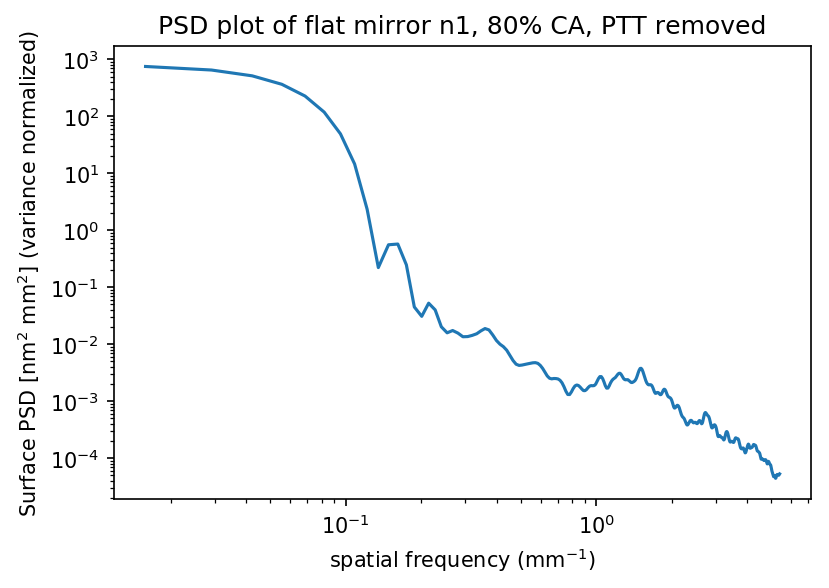

In [17]:
# convert mean from mm^2 mm^2 to nm^2 mm^2
mean_val_nm2 = [i*1e12 for i in mean_val]
plt.figure(dpi=150)
plt.loglog(k_val, mean_val_nm2)
plt.title('PSD plot of flat mirror n1, 80% CA, PTT removed')
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('Surface PSD [nm$^{2}$ mm$^{2}$] (variance normalized)') 

Text(0, 0.5, 'Surface PSD [mm$^{2}$ mm$^{2}$] (variance normalized)')

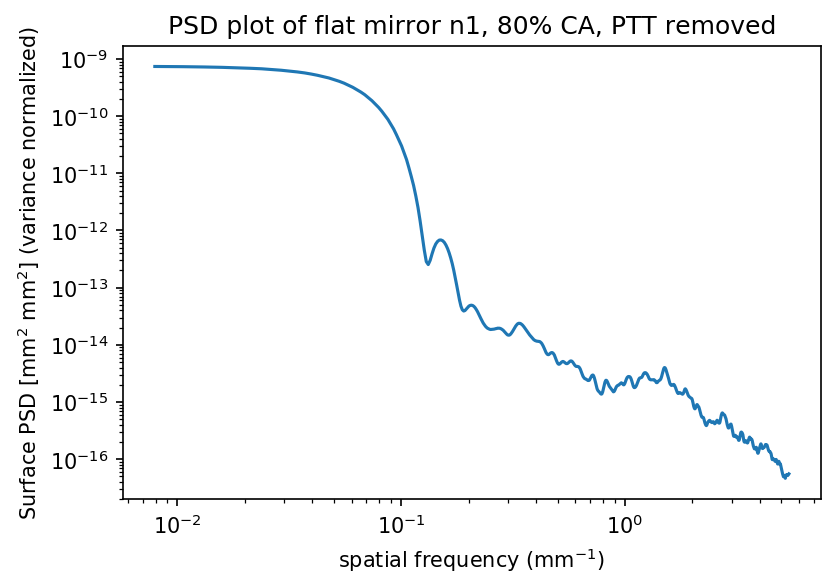

In [289]:
plt.figure(dpi=150)
plt.loglog(k_val, mean_val)
plt.title('PSD plot of flat mirror n1, 80% CA, PTT removed')
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('Surface PSD [mm$^{2}$ mm$^{2}$] (variance normalized)') 

In [219]:
# make grid for the ring to mask for average radial power value
shift=np.int(FT_freq.size/2)
maskY,maskX = np.ogrid[-shift:shift, -shift:shift]

# get the whole range of radial frequency
# it's radially symmetric, so cut to center line, then get right side for range.
radialFreq = magK[shift][shift:(2*shift)]
#k_val.append(radialFreq[r])

# initialize content
mean_val = [] # initialize empty list of median power values
k_val = [] # initialize empty list of frequencies

# set up radial ring parameters
dr=5 # 5 width, so 2 behind, 1 center, 2 front
r_halfside = np.int((dr-1)/2) # halfside for r
r=1 # initialize r value

# chug along through all the radial frequency values
while((r+r_halfside)<shift):
    ri = r - r_halfside # inner radius
    if ri > 0: # Only start adding in values when the inner radius is greater than 1
        radial_mask = psd.makeRingMask(maskY,maskX,ri,dr)
        radial_bin = psd.makeRingMaskBin(power_optic,radial_mask)
        mean_val.append(np.mean(radial_bin))
        k_val.append(radialFreq[r])
    r+=1 # iterate to the next r value in the loop.

Text(0, 0.5, 'do not trust scale - not normalized with variance')

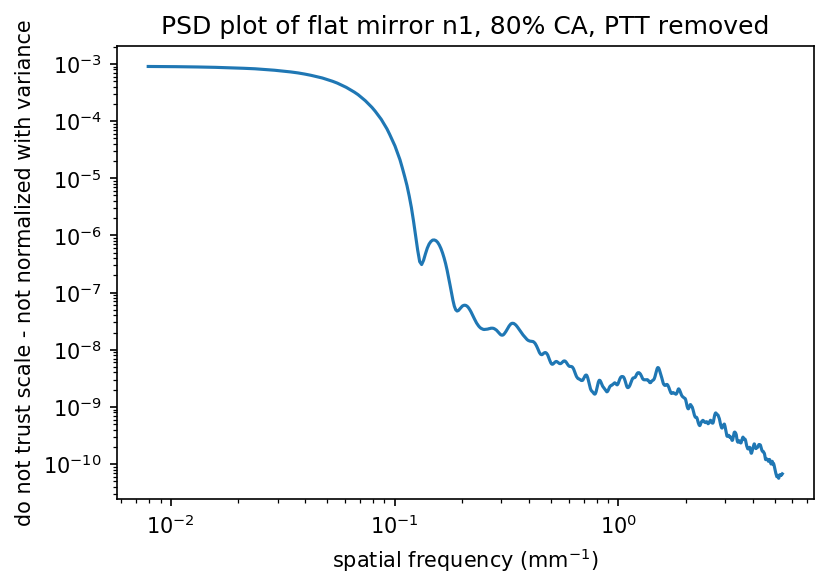

In [221]:
plt.figure(dpi=150)
plt.loglog(k_val, mean_val)
plt.title('PSD plot of flat mirror n1, 80% CA, PTT removed')
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('do not trust scale - not normalized with variance') 

Text(0, 0.5, 'power units need more thinking, do not trust scale')

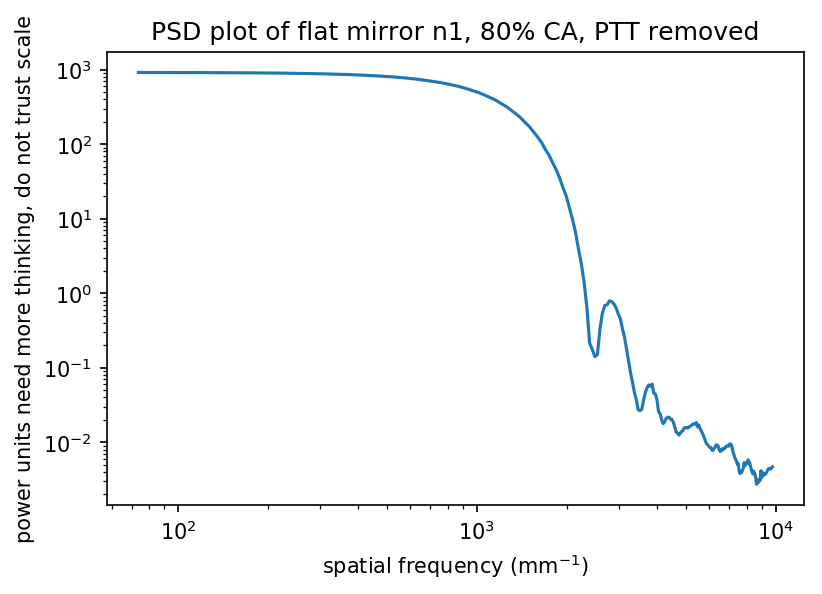

In [106]:
# oversample the data to prepare for FFTs
oversamp = 8
optic_wf = psd.zeroPadOversample(ap_win,oversamp)
zygo_wavelen = 633e-9*u.m
shift = 200 # wtf is this??? (do I need to do this?)
power_optic = psd.doCenterCrop(psd.calcPower2(optic_wf),shift)
# Make the spatial frequency mapping
optic_aper_diam = (25.4)*(80/100)/1000 *u.m # units: millimeters
freqMap = psd.SpatFreqMap(optic_aper_diam/2,shift*2)
radialFreq = freqMap[shift][shift:(2*shift)+1]
# Build the mask for the median radian power value
dr = 1 # assume 3 pixels forward to build the median
maskY,maskX = np.ogrid[-shift:shift, -shift:shift]
r = 1 # skip the center pixel
median_val = [] # initialize empty list of median power values
k_val = [] # initialize empty list of frequencies
while((r+dr)<(shift)):
    radial_mask = psd.makeRingMask(maskY,maskX,r,dr)
    radial_bin = psd.makeRingMaskBin(power_optic, radial_mask)
    median_val.append(np.median(radial_bin))
    k_val.append(psd.getRadialSpatFreq(radialFreq,r,dr))
    r = r+1
plt.figure(dpi=150)
plt.loglog(k_val, median_val)
plt.title('PSD plot of flat mirror n1, 80% CA, PTT removed')
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('power units need more thinking, do not trust scale') 

In [98]:
ap_fft = np.fft.fftshift(np.fft.fft2(ap_win))
ap_power = np.real(ap_fft*np.conjugate(ap_fft))

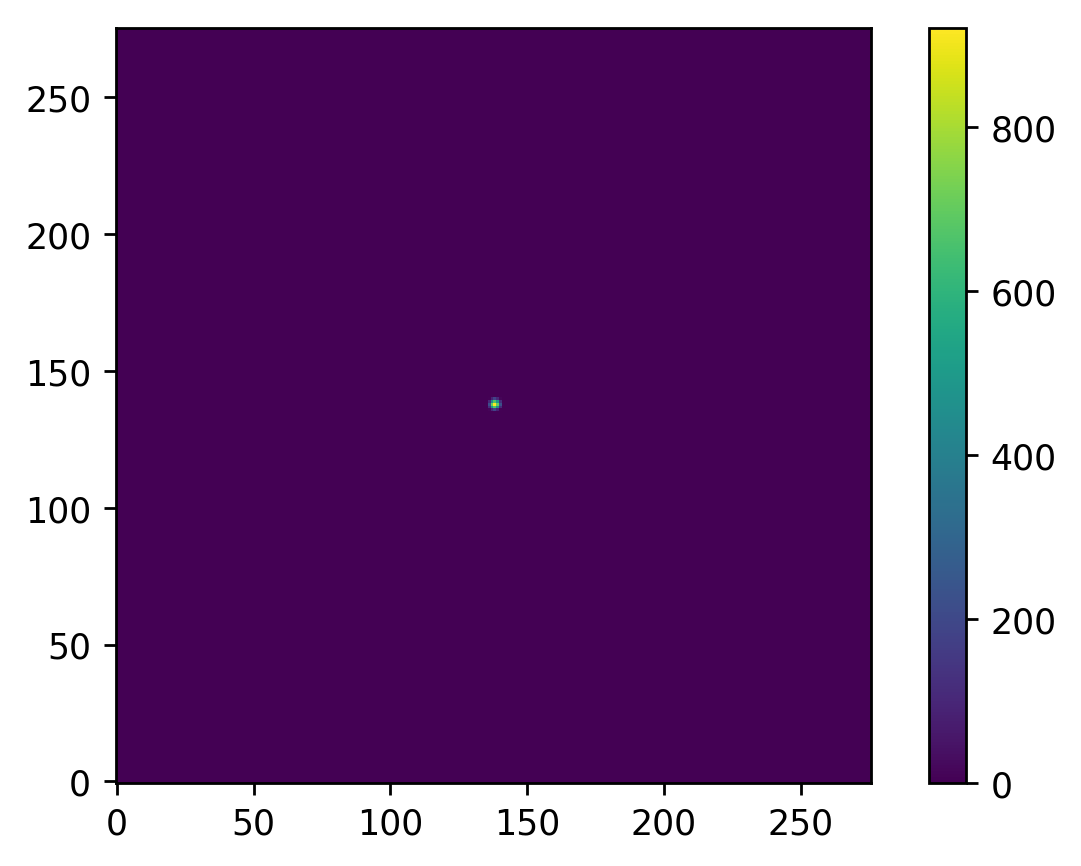

In [101]:
plt.figure(dpi=250)
plt.imshow(ap_power, origin='lower')
plt.colorbar()

Text(0.5, 1.0, 'padded')

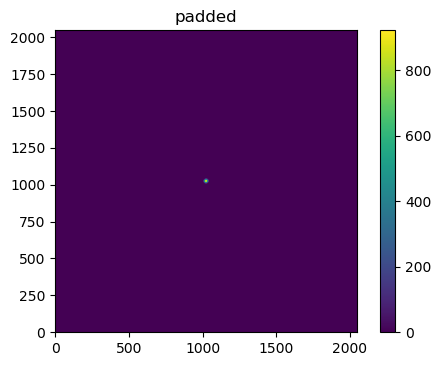

In [102]:
ap_win_pad = psd.zeroPadOversample(ap_win, 4)
ap_fft_pad = np.fft.fftshift(np.fft.fft2(ap_win_pad))
ap_power_pad = np.real(ap_fft_pad*np.conjugate(ap_fft_pad))
plt.figure(dpi=100)
plt.imshow(ap_power_pad, origin='lower')
plt.colorbar()
plt.title('padded')

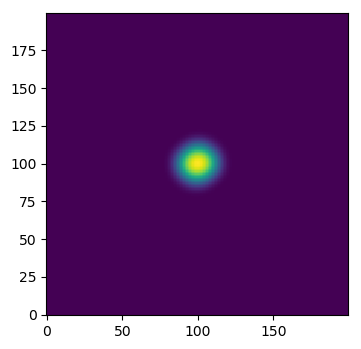

In [104]:
t=psd.doCenterCrop(ap_power_pad,100)
plt.figure(dpi=100)
plt.imshow(t,origin='lower')

In [17]:
active_ap = optic[circ_pattern==True]
ap_avg = np.mean(active_ap)
ap_avg # units of microns of surface

0.003486320284533944

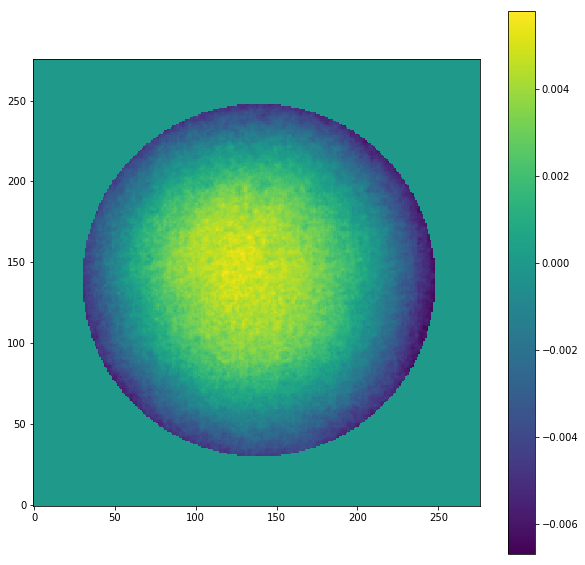

In [20]:
# subtract the mean
mask_submean = (mask - ap_avg)*circ_pattern
plt.figure(figsize=[10,10])
plt.imshow(mask_submean, origin='lower')
plt.colorbar()

In [21]:
active_ap = mask_submean[circ_pattern==True]
ap_var = np.var(active_ap)
ap_var

8.810319381772172e-06

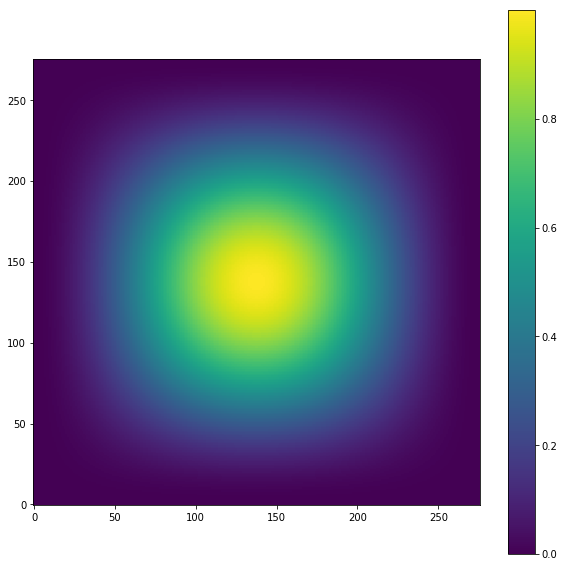

In [24]:
# apply hann window
hannWin = psd.makeHannWindow(np.shape(optic)[0])
plt.figure(figsize=[10,10])
plt.imshow(hannWin, origin='lower')
plt.colorbar()

In [ ]:




hannWin = psd.makeHannWindow(np.shape(optic)[0])
optic_win = optic * hannWin
#plt.imshow(oap_win); plt.colorbar()
oversamp = 8
optic_wf = psd.zeroPadOversample(optic_win,oversamp)
zygo_wavelen = 633e-9*u.m
shift = 200
power_optic = psd.doCenterCrop(psd.calcPower2(optic_wf),shift)
# Make the spatial frequency mapping
optic_aper_diam = (25.48/2)*(80/100)/1000 *u.m # units: millimeters
freqMap = psd.SpatFreqMap(optic_aper_diam,shift*2)
radialFreq = freqMap[shift][shift:(2*shift)+1]
# Build the mask for the median radian power value
dr = 1 # assume 3 pixels forward to build the median
maskY,maskX = np.ogrid[-shift:shift, -shift:shift]
r = 1 # skip the center pixel
median_val = [] # initialize empty list of median power values
k_val = [] # initialize empty list of frequencies
while((r+dr)<(shift)):
    radial_mask = psd.makeRingMask(maskY,maskX,r,dr)
    radial_bin = psd.makeRingMaskBin(power_optic, radial_mask)
    median_val.append(np.median(radial_bin))
    k_val.append(psd.getRadialSpatFreq(radialFreq,r,dr))
    r = r+1

Text(0, 0.5, 'power units need more thinking, do not trust scale')

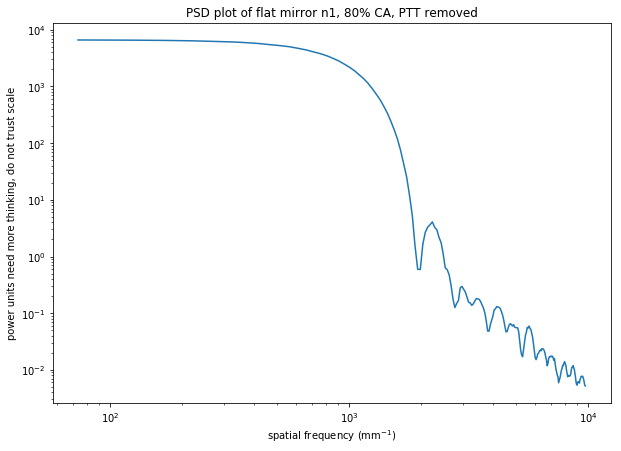

In [5]:
plt.figure(figsize=[10,7])
plt.loglog(k_val, median_val)
plt.title('PSD plot of flat mirror n1, 80% CA, PTT removed')
plt.xlabel('spatial frequency (mm$^{-1}$)')
plt.ylabel('power units need more thinking, do not trust scale') 